# Apache Spark - Analyzing Food Insecurity in NYC using KeyFoods Price Catalogs

The goal of this notebook is to study the food insecurity problem by looking at the listed prices of various food items across neighborhoods in NYC. Our hypothesis is that *people living in areas with higher food insecurity problems would pay more for the same items compared to those in more secured areas*. For the scope of work, we will only assess food products from KeyFoods supermarkets, one of the top 4 Supermarket Leaders in Metro New York (according [Food Trade News 2021 report](https://www.foodtradenews.com/2021/06/29/food-trade-news-2021-market-study-issue/)). In particular, we will use the following datasets:

### **`keyfood_products.csv`**

This CSV file contains the price information about 2 million food items listed on KeyFoods stores in NYC.

|store|department|upc|product|size|price|
|--|--|--|--|--|--|
102|bakery|102-28556000000|Store Prepared - Challah Egg|1 EA|\$4.99 each|
102|bakery|102-28781600000|Store Prepared - fw Cheesecake Plain 7 Inch|1 EA|\$27.99 each|
|...|...|...|...|...|...|

The details of the columns are as follows:

|Column|Description|
|--|--|
|**store** | The unique id of each store |
|**department**| The department (or aisle) that the food item belongs to. Possible values are:<br />`'bakery'`,`'beverages'`,`'breakfast'`,`'deli'`,`'frozen'`,`'international'`,<br/>`'meatandseafood'`,`'pantry'`,`'produce'`,`'refrigerated'`, and `'snacks'`|
|**upc**|The unique id for each item in a food store. It is often in the format of `SID-XXXXXXXXXX`,<br/> where `SID` is a store id if it's specific to a store, `UPC` if it's a general product, or `'KEY'` <br/> if it's a KeyFoodsproduct. If an item doesn't have any UPC code, this field will be `N/A`.|
|**product**|This is the listed name of the product|
|**size**|The unit that the product is being sold in|
|**price**|The price text of the product as shown on their websites. This is not a number but have<br/>been verified to start with the price mark`$XX.XX`. Note that for items without price<br/>information, this field could be listed as `Price not Available`|






### **`keyfood_nyc_stores.json`**

This JSON file contains information for all KeyFoods stores in NYC. There are a lot of details about each store, however, we are only interested in the following fields:

|Field|Description|
|--|--|
|**name** | This is the unique id of each store, which could be crosswalk with the **store** field above |
|**communityDistrict**|The community district code that the store belongs to. It's simply a larger geographical<br/> unit comparing to a zip code. More information can be found [here](https://communityprofiles.planning.nyc.gov/).|
|**foodInsecurity**|A food insecurity score computed for the community district that the stores belong to.<br/> This value has the range of 0 to 1 with 0 being without any food insecurity rish, and 1 <br/> has the most food insecure risk.|



### **`keyfood_sample_items.csv`**

This data contains the list of 22 food items that we would like to study initially to assess our hypothesis. For each item, we have the UPC code (which needs to be generalized across store) and the item name. Here is the list:

|UPC code|Item Name|
|--|--|
|SID-20308200000|Broccoli Crowns|
|KEY-000000004094|Fresh Produce - Carrot Bunch|
|KEY-000000004062|Fresh Produce - Cucumbers|
|SID-00000004072|Fresh Produce - Potatoes Russet|
|SID-00000004131|Fresh Produce - Apples Fuji Large|
|KEY-00000004013|Produce - Orange Navel 113|
|UPC-048500001004|Tropicana - Juice Orange Pure Prem Orig|
|UPC-017400108700|Carolina - Whole Grain Brown Rice|
|UPC-016000487697|General Mills - Cherrios Multi Grain Cereal|
|UPC-073296027686|Urban Meadow - 100 Whole Wheat Bread|
|UPC-048000013651|Chicken of the Sea - Solid Wht Albacore Tuna in Oil|
|SID-20115200000|Beef - Beef Semi Bnls Chuck Stk|
|SID-28080600000|Perdue - Split Chicken Breast Fam Pack|
|UPC-073296057461|Urban Meadow - Plain Low Fat Yogurt|
|UPC-041757021443|Laughing Cow - White Cheddar Wedges|
|UPC-073296069280|Urban Meadow - Large White Eggs|
|UPC-088365000347|Cream O Land - Gallon 2% Milk|
|UPC-072940744016|Redpack - Tomato Crushed|
|UPC-051500255162|Jif - Creamy Peanut Butter|
|UPC-073296025903|Urban Meadow - Canola Oil|
|UPC-041331124461|Goya - Beans Cannelini Can|
|UPC-014500001894|Birds Eye - Spinach Leaf|

where `SID` should be replaced with the store id.


## Environment Setup


In [ ]:
%%shell
gdown --quiet 1O1U_t-cpmValVK2mjdTzcFxIbGw05vOw
gdown --quiet 1YUBKrtNV3QUz1RutMnMbJdQj7rv-Lkd5
gdown --quiet 1f79oETtvN3NQLYPnVGhurE1UBDP4IQP-
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=579502e3a029e6ec1d489f0024d9bcc80cf690db6eaab46fc67629f7b8c97d39
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import IPython
%matplotlib inline
IPython.display.set_matplotlib_formats('svg')
pd.plotting.register_matplotlib_converters()
sns.set_style("whitegrid")

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
sc = pyspark.SparkContext.getOrCreate()
spark = SparkSession(sc)
spark

<ipython-input-55-bd29a5ba4fde>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats('svg')


## Task 1 - Visualizing Distributions of Listed Food Prices

In the first task, we would like to see how the listed prices for food items vary across stores. For each item in the sample list provided in `keyfood_sample_items.csv`, we can simply overlay a [strip plot](https://seaborn.pydata.org/generated/seaborn.stripplot.html) with a [violin plot](https://seaborn.pydata.org/generated/seaborn.violinplot.html). In addition, to better correlate the price distribution with the food insecurity risk, we will color the markers by the percentage of food insecurity (derived from the `foodInsecurity` field in `keyfood_nyc_stores.json`).

To produce the plot, we need to following data, where each row represents a listing of the sample food item from a store.

| Item Name	| Price ($) | % Food Insecurity |
|--|--|--|
|Urban Meadow - 100 Whole Wheat Bread | 2.29 | 11 |
|General Mills - Cherrios Multi Grain Cereal | 6.79 | 11 |
|Birds Eye - Spinach Leaf | 2.29 | 11 |
|Beef - Beef Semi Bnls Chuck Stk | 7.99 | 11 |
|Chicken of the Sea - Solid Wht Albacore Tuna in Oil | 2.49 | 11 |
| ... | ... | ... |



Using either Spark's RDD or Spark's DataFrame transformations.

* Items must be filtered by UPC codes and names provided in the `keyfood_sample_items.csv`. UPC codes are considered equal if their numeric parts (the second portion after the `-`) are the same. For example, `SID-20308200000` is the same as `102-20308200000`, `KEY-20308200000`, etc.

* `Item Name` must be taken the sample items when there's a UPC code match (as defined above).

* `Price` should be extracted from the `price` column of `keyfood_products.csv`. The prefix `$` should be removed, and the output price should be converted to a float number (i.e. not a string).

*  `% Food Insecurity` is simply the percentage of the `foodInsecurity` score, i.e. by multiplying `foodInsecruity` by `100`.


In [ ]:
#header's for products
products = sc.textFile('keyfood_products.csv',use_unicode=True)

list(enumerate(products.first().split(',')))

[(0, 'store'),
 (1, 'department'),
 (2, 'upc'),
 (3, 'product'),
 (4, 'size'),
 (5, 'price')]

In [ ]:
#headers for sample items 
sample_items = sc.textFile('keyfood_sample_items.csv')

list(enumerate(sample_items.first().split(',')))

[(0, 'UPC code'), (1, 'Item Name')]

In [ ]:
#function to extract csv data for rdd
def extract_products_data(index,rows):
  #skip header
  if index == 0:
    next(rows)
  #read csv data yielding entire row of data 
  import csv
  reader = csv.reader(rows)
  for row in reader:
    #checking if index 2 of the row is N/A
    if row[2] != 'N/A':
      yield tuple(row)

#function to extract csv data for rdd
def extract_items_data(index,rows):
  #skip header
  if index == 0:
    next(rows)
  #read csv data yielding entire row of data
  import csv
  reader = csv.reader(rows)
  for row in reader:
      yield tuple(row)

In [ ]:
#loading products, getting the UPC, store, price, and doing manipulations
#like getting second part of UPC code, converting price to float 
products = sc.textFile('keyfood_products.csv',use_unicode=True).mapPartitionsWithIndex(extract_products_data)\
  .map(lambda x: (x[2].split('-')[1],(x[0],float(x[5].split(u'\xa0')[0].replace('$','')))))

print(products.count())
products.take(5)

2234912


[('28556000000', ('102', 4.99)),
 ('28781600000', ('102', 27.99)),
 ('00000000099', ('102', 1.5)),
 ('00000000191', ('102', 5.49)),
 ('22794900000', ('102', 7.99))]

In [ ]:
#loading in samples into rdd, and splitting UPC and getting the second part 
sample_items = sc.textFile('keyfood_sample_items.csv').mapPartitionsWithIndex(extract_items_data)\
  .map(lambda x: (x[0].split('-')[1],(x[1],)))

print(sample_items.count())
sample_items.take(5)


22


[('20308200000', ('Broccoli Crowns',)),
 ('000000004094', ('Fresh Produce - Carrot Bunch',)),
 ('000000004062', ('Fresh Produce - Cucumbers',)),
 ('00000004072', ('Fresh Produce - Potatoes Russet',)),
 ('00000004131', ('Fresh Produce - Apples Fuji Large',))]

In [ ]:
#import lib for reading json
import json

#define generator function for extracting data from keyfood_nyc_stores.json
def extract_json_data(json_f):
  #opening file 
  with open(json_f) as f:
    #loading json file using json.load
    data = json.load(f)
    #looping through all the keys
    for key in data.keys():
      #for each record, extract the needed info 
      record = data[key]
      yield (record['name'],(record['communityDistrict'],record['foodInsecurity']))

#convert into json into rdd
nyc_stores = sc.parallelize(extract_json_data('keyfood_nyc_stores.json'))

nyc_stores.take(4)

[('1920', ('302', 0.133904746681599)),
 ('1918', ('308', 0.169051320723646)),
 ('1436', ('103', 0.179323946238924)),
 ('2314', ('308', 0.169051320723646))]

In [ ]:
#joining the sample_items, products, and nyc_stores rdd to get desired output 
outputTask1 = sample_items.join(products).mapValues(lambda x: x[0]+x[1])\
  .map(lambda x: (x[1][1],(x[1][0],x[1][2]))).join(nyc_stores.mapValues(lambda x: (int(round(x[1]*100)),)))\
  .mapValues(lambda x: x[0]+x[1]).values()

## DO NOT EDIT BELOW
outputTask1 = outputTask1.cache()
outputTask1.count()

3116

In [ ]:
outputTask1.take(5)

[('Fresh Produce - Apples Fuji Large', 2.99, 9),
 ('Jif - Creamy Peanut Butter', 2.99, 9),
 ('Urban Meadow - Canola Oil', 5.49, 9),
 ('Tropicana - Juice Orange Pure Prem Orig', 4.09, 9),
 ('Urban Meadow - 100 Whole Wheat Bread', 2.29, 9)]

<ipython-input-12-95592f60a498>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in ax.legend_.legendHandles:


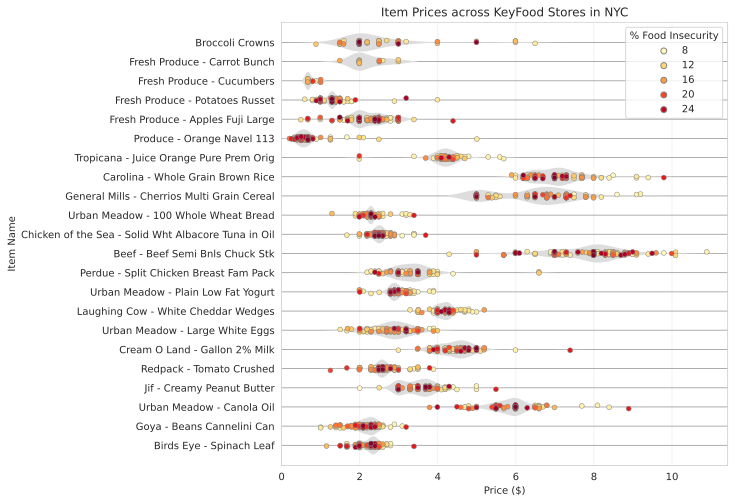

In [ ]:
#@title
def dfTask1(data):
    rdd = data.rdd if hasattr(data, 'rdd') else data
    if rdd.count()>10000:
        raise Exception('`outputTask1` has too many rows')
    rows = map(lambda x: (x[0], x[1], int(x[2])), rdd.collect())
    return pd.DataFrame(data=rows, columns=['Item Name','Price ($)','% Food Insecurity'])

def plotTask1(data, figsize=(8,8)):
    itemNames = pd.read_csv('keyfood_sample_items.csv')['Item Name']
    itemKey = dict(map(reversed,enumerate(itemNames)))
    df = dfTask1(data).sort_values(
        by = ['Item Name', '% Food Insecurity'],
        key = lambda x: list(map(lambda y: itemKey.get(y,y), x)))
    plt.figure(figsize=figsize)
    ax = sns.violinplot(x="Price ($)", y="Item Name", data=df, linewidth=0,
                        color='#ddd', scale='width', width=0.95)
    idx = len(ax.collections)
    sns.scatterplot(x="Price ($)", y="Item Name", hue='% Food Insecurity', data=df,
                    s=24, linewidth=0.5, edgecolor='gray', palette='YlOrRd')
    for h in ax.legend_.legendHandles: 
        h.set_edgecolor('gray')
    pts = ax.collections[idx]
    pts.set_offsets(pts.get_offsets() + np.c_[np.zeros(len(df)),
                                            np.random.uniform(-.1, .1, len(df))])
    ax.set_xlim(left=0)
    ax.xaxis.grid(color='#eee')
    ax.yaxis.grid(color='#999')
    ax.set_title('Item Prices across KeyFood Stores in NYC')
    return ax

if 'outputTask1' not in locals():
    raise Exception('There is no `outputTask1` produced in Task 1.A')

plotTask1(outputTask1);

## Task 2 - Finding the Highest Priced Items in Areas with Food Insecurity

Examining the plot from Task 1, we could notice many cases where product prices are higher in areas with high food insecurity. For example, the highest priced *Cream O Land - Gallon 2% Milk* is in the area with a high `% Food Insecurity` value (the right most marker has a saturated red, approximately 20%). This suggests that our hypothesis might hold. At this point, we could perform a full *Null Hypothesis Test*, but before that, we would like to expand our study beyond just the sample items.

In particular, we would like to find all products that meets all of the conditions below:

1.  Must be sold in at least 3 stores, each with a food insecurity risk of `low`, `medium`, and `high`, respectively. The risk is based on the `foodInsecurity` value of each store, and computed as follows:

|foodInsecurity|Risk Rating|
|--|--|
|<=0.09|low|
|>0.09 and <=0.13| n/a|
|>0.13 and <=0.16| medium|
|>0.16 and <=0.23| n/a|
|>0.23| high|

2. The highest priced location has the risk rating of `high`.

3. The standard deviation of the product prices must be more than `$1`, i.e. when we collect all listed prices of the product based on its UPC, and compute the standard deviation, its value should be larger than `1`.

The task is to find the list of all UPC codes (only the second part after the `-` in `SID-XXXXXXXXXXX`) that meet such conditions along with its `department` value.

Using either Spark's RDD or Spark's DataFrame transformations. The output must be placed in the `outputTask2` variable with the following column order:

| Extracted UPC Code | Item Name | Department |
|--|--|--|
|073296027686 | Urban Meadow - 100 Whole Wheat Bread | refrigerated |
|20308200000 | Broccoli Crowns | produce |
| ... | ... | ... |

* The data must be sorted by the **Extracted UPC Code** alphabetically (i.e. as strings and not as numbers).

* **Item Name** can be taken from any of the product instance.

In [ ]:
test_record = [
   ('890', 'medium', 4.49),
   ('2374', 'medium', 4.19),
   ('313', 'high', 123213.19),
   ('2344', 'n/a', 23.19)]

#function to filter for task 2 
def task2_filter(data):
  #importing library 
  import statistics
  #unpacking list of tuples into tuples of specific data
  stores,risk_rating,price = zip(*data)
  #check that the product is sold in at least 3 stores, each with a food insecurity risk of low, medium, high 
  #check if the highest priced location has a risk rating of high 
  #check if the stadnard deciation of product prices is greater than 1
  if (len({'high','medium','low'}.intersection(set(risk_rating)))==3) and ('high' in sorted(list(zip(risk_rating,price)),key = lambda x: (-x[1],x[0]))[0]) and (statistics.stdev(price) > 1.0):
    return True
  else:
    return False 

task2_filter(test_record)

False

In [ ]:
#function to convert food insecurity score to risk rating 
def risk_rating(foodInsecurity):
  if foodInsecurity <= 0.09:
    return 'low'
  elif foodInsecurity > 0.13 and foodInsecurity <= 0.16:
    return 'medium'
  elif foodInsecurity > 0.23:
    return 'high'
  else:
    return 'n/a'

In [ ]:
#rdd to find the products that are sold in at least 3 stores, each with a food insecurity risk of low, medium, and high,
#the highest price is matched with a high risk rating store, 
#and the standard deviation of the prices is greater than 1
store_UPC_risk_rating = sc.textFile('keyfood_products.csv',use_unicode=True).mapPartitionsWithIndex(extract_products_data)\
  .map(lambda x: (x[0],(x[2].split('-')[1],float(x[5].split(u'\xa0')[0].replace('$',''))))).join(nyc_stores.mapValues(lambda x: (x[1],)))\
  .mapValues(lambda x: x[0]+x[1]).mapValues(lambda x: (x[0],risk_rating(x[2]),x[1])).map(lambda x: (x[1][0],(x[0],x[1][1],x[1][2])))\
  .groupByKey().filter(lambda x: task2_filter(list(x[1]))).map(lambda x: (x[0],list(x[1])))

store_UPC_risk_rating.count()

96

In [ ]:
#getting the UPC code, product name, and department for output
name_department = sc.textFile('keyfood_products.csv',use_unicode=True).mapPartitionsWithIndex(extract_products_data)\
  .map(lambda x: (x[2].split('-')[1],(x[3],x[1]))).groupByKey().mapValues(lambda x: list(x)[0])

name_department.take(5)

[('22795000000', ('Store Prepared - White Chocolate Cut', 'bakery')),
 ('00000000001', ('Bagels', 'bakery')),
 ('044355901575', ('Modern Baker - Poppy Kaiser Rolls 6Pks', 'bakery')),
 ('051785318507', ("Michael's - Hot Cross Buns", 'bakery')),
 ('048121102081', ("Thomas' - English Muffin 6pk", 'bakery'))]

In [ ]:
#formatting the data for the validation script below 
#getting UPC code, product name, and department. then sorted on UPC code 
outputTask2 = store_UPC_risk_rating.join(name_department).map(lambda x: (x[0],x[1][1][0],x[1][1][1])).sortBy(keyfunc = lambda x: x[0])

## DO NOT EDIT BELOW
outputTask2 = outputTask2.cache()
outputTask2.count()

96

In [ ]:
outputTask2.take(5)

[('00000000003', 'Baguette', 'bakery'),
 ('00000000200', "Bakery ea Local Plu's", 'bakery'),
 ('00000004034', 'Fresh Produce - Honeydew', 'produce'),
 ('00000004080', 'Way Better - Asparagus', 'produce'),
 ('00000004109', 'Quickie - Apple Crispin Mutsu', 'produce')]

In [ ]:
#@title
def dfTask2(data):
    rdd = data.rdd if hasattr(data, 'rdd') else data
    if rdd.count()>1000:
        raise Exception('`outputTask2` has too many rows')    
    return pd.DataFrame(data=rdd.collect(), 
                        columns=['Extracted UPC Code','Item Name','Department'])

if 'outputTask2' not in locals():
    raise Exception('There is no `outputTask2` produced in Task 2')

dfTask2(outputTask2).groupby('Department').size()

Department
bakery             4
beverages          2
breakfast          1
deli               4
frozen            12
meatandseafood     7
pantry            20
produce           40
refrigerated       3
snacks             3
dtype: int64

## Task 3 - Run on DataProc

We will convert Task 1 into a single `.py` file named `BDM_HW4_EMPLID_LastName.py` that can be executed on any DataProc cluster.

In [ ]:
#function for opening csv. testing for script below 
def open_csv(file):
  import csv
  with open(file) as f:
    data = csv.reader(f)
    for i,row in enumerate(data):
      if i == 0:
        continue
      yield tuple(row)

test = sc.parallelize(open_csv('keyfood_sample_items.csv'))

In [ ]:
test.count()

22

In [ ]:
%%writefile BDM_HW4_24363838_Lau.py
#importing libraries 
import pyspark 
import sys
import json
import os 

#function to extract csv data for rdd
def extract_products_data(index,rows):
  #skip header
  if index == 0:
    next(rows)
  #read csv data yielding entire row of data 
  import csv
  reader = csv.reader(rows)
  for row in reader:
    #checking if index 2 of the row is N/A
    if row[2] != 'N/A':
      yield tuple(row)

#function to extract csv data for rdd
def extract_items_data(index,rows):
  #skip header
  if index == 0:
    next(rows)
  #read csv data yielding entire row of data
  import csv
  reader = csv.reader(rows)
  for row in reader:
      yield tuple(row)

#define generator function for extracting data from keyfood_nyc_stores.json
def extract_json_data(json_f):
  #opening file 
  with open(json_f) as f:
    #loading json file using json.load
    data = json.load(f)
    #looping through all the keys
    for key in data.keys():
      #for each record, extract the needed info 
      record = data[key]
      yield (record['name'],(record['communityDistrict'],record['foodInsecurity']))

#function to open csv file to read in rdd 
def open_csv(file):
  import csv
  with open(file) as f:
    data = csv.reader(f)
    for i,row in enumerate(data):
      if i == 0:
        continue
      yield tuple(row)

#main
def main():
    #spark session
    sc = pyspark.SparkContext.getOrCreate()

    #convert products csv into rdd, while extracting needed data and manipulating data
    #get second part of UPC code and get float for price
    products = sc.textFile('gs://bdma/data/keyfood_products.csv',use_unicode=True).mapPartitionsWithIndex(extract_products_data).map(lambda x: (x[2].split('-')[1],(x[0],float(x[5].split(u'\xa0')[0].replace('$','')))))

    #convert samples csv into rdd, extracting the UPC code, product name
    sample_items = sc.parallelize(open_csv('keyfood_sample_items.csv')).map(lambda x: (x[0].split('-')[1],(x[1],))) 

    #convert into json into rdd
    nyc_stores = sc.parallelize(extract_json_data('keyfood_nyc_stores.json'))

    #generate output of product name, price, and food insecurity 
    #joining the sample_items, products, and nyc_stores rdd to get desired output 
    output = sample_items.join(products).mapValues(lambda x: x[0]+x[1]).map(lambda x: (x[1][1],(x[1][0],x[1][2]))).join(nyc_stores.mapValues(lambda x: (int(round(x[1]*100)),))).mapValues(lambda x: x[0]+x[1]).values()

    #printing count of output
    print(f'Count of Resultant RDD: {output.count()}')

    #saving output as text file
    output.saveAsTextFile(sys.argv[1])
     

if __name__ == '__main__':
    main()


Overwriting BDM_HW4_24363838_Lau.py


In [ ]:
#testing on local files
!python BDM_HW4_24363838_Lau.py

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/03 06:02:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/03 06:02:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Count of Resultant RDD: 3116


In [1]:
!pip install google-cloud-dataproc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.5/307.5 kB 9.3 MB/s eta 0:00:00


In [1]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=5mJrVZl7Ql4u1bHNL71dfiddBfYDi2&prompt=consent&access_type=offline&code_challenge=DNVm0Oa5QEKGi3ZPD59JtWwqd6ujgy9GF66s6X8PpWk&code_challenge_method=S256

Enter authorization code: 4/0AbUR2VM0x7u4xcu8WWSO3zInr-mOm91QQE6VXlKXVMs7JWZey8FH93iOQH3V25PffBLCRg

You are now logged in as [alau002@citymail.cuny.edu].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID

In [2]:
!gcloud projects list

PROJECT_ID      NAME     PROJECT_NUMBER
bigdata-380720  BigData  267580964279


In [ ]:
!gcloud config set project bigdata-380720
!gcloud config set compute/region us-west1
!gcloud config set compute/zone us-west1-a
!gcloud config set dataproc/region us-west1

Updated property [core/project].
Updated property [compute/region].
Updated property [compute/zone].
Updated property [dataproc/region].


In [ ]:
!gcloud dataproc clusters create bdm-hw4 --enable-component-gateway --region us-west1 --zone us-west1-a --master-machine-type n1-standard-4 --master-boot-disk-size 500 --num-workers 2 --worker-machine-type n1-standard-4 --worker-boot-disk-size 500 --image-version 2.0-debian10 --project bigdata-380720

Waiting on operation [projects/bigdata-380720/regions/us-west1/operations/253638cd-7a8b-3d39-9c70-e5fb4835cccb].

Created [https://dataproc.googleapis.com/v1/projects/bigdata-380720/regions/us-west1/clusters/bdm-hw4] Cluster placed in zone [us-west1-a].


In [ ]:
!gcloud dataproc clusters list

NAME     PLATFORM  WORKER_COUNT  PREEMPTIBLE_WORKER_COUNT  STATUS   ZONE        SCHEDULED_DELETE
bdm-hw4  GCE       2                                       RUNNING  us-west1-a


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster bdm-hw4 --files keyfood_nyc_stores.json,keyfood_sample_items.csv \
--properties=spark.hadoop.fs.gs.requester.pays.mode=AUTO,spark.hadoop.fs.gs.requester.pays.project.id=bigdata-380720 \
BDM_HW4_24363838_Lau.py -- gs://bdma/shared/2023_spring/HW4/24363838_Lau

Job [42308a657d534fcd80368bd1c29f1f89] submitted.
Waiting for job output...
23/05/03 06:30:14 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/03 06:30:15 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/03 06:30:15 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/03 06:30:15 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
23/05/03 06:30:15 INFO org.sparkproject.jetty.util.log: Logging initialized @7216ms to org.sparkproject.jetty.util.log.Slf4jLog
23/05/03 06:30:15 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_362-b09
23/05/03 06:30:15 INFO org.sparkproject.jetty.server.Server: Started @7394ms
23/05/03 06:30:15 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@2ef827a2{HTTP/1.1, (http/1.1)}{0.0.0.0:34249}
23/05/03 06:30:16 INFO org.apache.hadoop.yarn.client.RMPro

In [ ]:
!gsutil -u bigdata-380720 ls gs://bdma/shared/2023_spring/HW4/24363838_Lau/

gs://bdma/shared/2023_spring/HW4/24363838_Lau/
gs://bdma/shared/2023_spring/HW4/24363838_Lau/_SUCCESS
gs://bdma/shared/2023_spring/HW4/24363838_Lau/part-00000
gs://bdma/shared/2023_spring/HW4/24363838_Lau/part-00001
gs://bdma/shared/2023_spring/HW4/24363838_Lau/part-00002
gs://bdma/shared/2023_spring/HW4/24363838_Lau/part-00003
gs://bdma/shared/2023_spring/HW4/24363838_Lau/part-00004
gs://bdma/shared/2023_spring/HW4/24363838_Lau/part-00005


In [6]:
!gsutil -u bigdata-380720 cat gs://bdma/shared/2023_spring/HW4/24363838_Lau/part*

('Chicken of the Sea - Solid Wht Albacore Tuna in Oil', 2.49, 11)
('Jif - Creamy Peanut Butter', 2.99, 11)
('Redpack - Tomato Crushed', 2.59, 11)
('Urban Meadow - Canola Oil', 5.99, 11)
('Produce - Orange Navel 113', 0.5, 11)
('Fresh Produce - Apples Fuji Large', 1.99, 11)
('Urban Meadow - Plain Low Fat Yogurt', 2.89, 11)
('Urban Meadow - 100 Whole Wheat Bread', 2.29, 11)
('General Mills - Cherrios Multi Grain Cereal', 6.79, 11)
('Birds Eye - Spinach Leaf', 2.29, 11)
('Laughing Cow - White Cheddar Wedges', 4.19, 11)
('Fresh Produce - Potatoes Russet', 1.29, 11)
('Carolina - Whole Grain Brown Rice', 6.99, 11)
('Beef - Beef Semi Bnls Chuck Stk', 7.99, 11)
('Goya - Beans Cannelini Can', 2.29, 11)
('Urban Meadow - Large White Eggs', 2.89, 11)
('Chicken of the Sea - Solid Wht Albacore Tuna in Oil', 2.39, 9)
('Jif - Creamy Peanut Butter', 2.99, 9)
('Redpack - Tomato Crushed', 2.49, 9)
('Urban Meadow - Canola Oil', 5.49, 9)
('Produce - Orange Navel 113', 0.67, 9)
('Fresh Produce - Apples Fuji

In [ ]:
#!gsutil -u bigdata-380720 rm -r gs://bdma/shared/2023_spring/HW4/24363838_Lau/

In [ ]:
!gcloud dataproc clusters delete bdm-hw4 -q
!gcloud dataproc clusters list

Waiting on operation [projects/bigdata-380720/regions/us-west1/operations/c6c1b959-5bb9-3def-8332-cb5ebed70000].
Deleted [https://dataproc.googleapis.com/v1/projects/bigdata-380720/regions/us-west1/clusters/bdm-hw4].
Listed 0 items.


In [ ]:
!gcloud dataproc clusters list

Listed 0 items.
